In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import LMC
import archinfo
import imp
import astropy.stats
import scipy.signal as sig
import scipy.optimize as op
import dcor
import random

from scipy import stats
from timeit import default_timer

from sklearn.cluster   import KMeans
from sklearn.cluster   import SpectralClustering
from sklearn.neighbors import DistanceMetric

from KDEpy import FFTKDE

pi = np.pi

MJUPITER = 1.898e27     #all in SI units
MEARTH = 5.972e24
MSUN = 1.989e30
RJUPITER = 69.911e6
RSUN = 696.34e6
MSATURN = 5.6834e26
BIGG = 6.67e-11
MURANUS = 8.681e25

REARTH = 6371e3
RNEPTUNE = 24622e3

In [2]:
my_file = 'C:/Users/djhoo/Documents/maiasaurus-master/catalogues/exoarchive_ipac_confirmed_200507.csv'  #reading in file

raw_data = []
with open(my_file) as infile:
    reader = csv.reader(infile)
    
    for row in reader:
        raw_data.append(row)
        
KEYS = raw_data[77]
VALUES = raw_data[78:]

def get_key(keyname, keys = KEYS, values = VALUES):
    '''
    keyname must be a string
    '''
    i = keys.index(keyname)
    arr = []
    for row in values:
        arr.append(row[i])
    return arr

In [3]:
'''
What I need:
- star name 
- planet radius --> comes from planet mass
- star mass
- planet mass
- planet semi-major axis --> comes from planet's period
- star radius
'''

d = {}
d['starname'] = get_key('pl_hostname')  #get star name

d['radius'] = get_key('pl_radj')  #get radius of planets (Jupiter radius)
d['star_radius'] = get_key('st_rad')  #get radius of star (solar radii)

d['mp'] = get_key('pl_bmassj')  #get mass of planets (in Jupiter masses)
                                #mass can be expressed as Msin(i), where i is the inclination

d['ms'] = get_key('st_mass')  #get mass of stars (in solar masses)

d['a'] = get_key('pl_orbsmax')  #get planet's semi-major axis (in AU)

d['p'] = get_key('pl_orbper')  #get planet's period (in days)

In [4]:
def is_number(num):
    try:
        float(num)
        return True
    except ValueError:
        return False

stars = []   #convert to arrays
rp = []
rs = []
mp = []
ms = []
a = []
p = []

for i in range(len(d['a'])):
    if is_number(d['mp'][i]) and is_number(d['ms'][i]) and is_number(d['a'][i]) and is_number(d['star_radius'][i]) \
    and is_number(d['p'][i]):
        stars.append(d['starname'][i])
        rp.append(d['radius'][i])
        mp.append(d['mp'][i])
        ms.append(d['ms'][i])
        a.append(d['a'][i])
        rs.append(d['star_radius'][i])
        p.append(d['p'][i])
        
        
for i in range(len(mp)):
    if rp[i] == '':
        m = float(mp[i])                        #using the mass-radius relation to convert m to r
        if m*MJUPITER/MEARTH <= 2:              #coefficients taken from Chen and Kipping (2016)
            rp[i] = str(((m*MJUPITER/MEARTH)**0.28)*REARTH/RJUPITER)
        elif m <= 0.41:
            rp[i] = str((((m*MJUPITER/MEARTH)**0.59)*REARTH - 1.483*REARTH)/RJUPITER)
        elif m*MJUPITER/MSUN <= 0.08:
            rp[i] = str((((m*MJUPITER/MEARTH)**-0.04)*REARTH + 10.179*REARTH)/RJUPITER)
        else:
            rp[i] = str(((m*MJUPITER/MEARTH)**0.88)*REARTH/RJUPITER)
        

In [5]:
def convert_to_float(arr):
    final = []
    for a in arr:
        final.append(float(a))
    return final

rp = convert_to_float(rp)
rs = convert_to_float(rs)
mp = convert_to_float(mp)
ms = convert_to_float(ms)
a = convert_to_float(a)
p = convert_to_float(p)

In [6]:
uniquestars = []
for s in stars:
    if s not in uniquestars:              #one instance of each star in uniquestars
        uniquestars.append(s)

In [7]:
def split_array(arr, s = stars, u = uniquestars):
    final_array = []
    corresponding_stars = []
    for i in range(len(u)):
        mini_array = []
        for j in range(len(s)):
            if s[j] == u[i]:
                mini_array.append(arr[j])
        if len(mini_array) >= 3:
            final_array.append(mini_array)
            corresponding_stars.append(u[i])
    return final_array, corresponding_stars

def get_rprs(rp, rs):
    rprs = []
    for i in range(len(rp)):
        rprs.append(rp[i]*RJUPITER/(rs[i]*RSUN))
    return rprs

def get_mu(mp, ms):
    Mstar = ms[0]
    mu = 0
    for i in range(len(mp)):
        mu = mu + mp[i]*MJUPITER/(Mstar*MSUN)
    return mu

def error_rprs(r):
    r_final = []
    for i in range(len(r)):
        if r[i] < 1:
            r_final.append(r[i])
    return r_final

rprs = get_rprs(rp, rs)

In [8]:
def convert_masses(arr):
    arr_new = []
    for a in arr:
        arr_new.append(a*MEARTH/MJUPITER)
    return arr_new

def P_to_a(periods, star_mass):
    a = []
    for p in periods:
        p = p*24*60*60
        a.append((p**2*BIGG*star_mass/(4*pi**2))**(1/3)/1.496e11)
    return a

rprs_final, stars_that_matter = split_array(rprs)
mp_final, stars_that_matter = split_array(mp)
ms_final, stars_that_matter = split_array(ms)
a_final, stars_that_matter = split_array(a)
p_final, stars_that_matter = split_array(p)

#adding in values for Jupiter
jupiter_rprs = [0.02604, 0.02231, 0.03762, 0.03446]
jupiter_mp =  convert_masses([0.01495, 0.008035, 0.02481, 0.01801])
jupiter_ms = [MJUPITER/MSUN]*4
jupiter_a = [0.002819, 0.004485, 0.007155, 0.01258]
jupiter_p = [1.769, 3.551, 7.155, 16.69]

rprs_final.append(jupiter_rprs)
mp_final.append(jupiter_mp)
ms_final.append(jupiter_ms)
a_final.append(jupiter_a)
p_final.append(jupiter_p)
stars_that_matter.append("Jupiter")

#adding in values for Saturn
saturn_rprs = [0.0034, 0.00432, 0.00911, 0.00963, 0.0131, 0.04417, 0.0126]
saturn_mp = convert_masses([6.347e-6, 1.809e-5, 1.034e-4, 1.834e-4, 3.865e-4, 2.252e-2, 3.023e-4])
saturn_ms = [MSATURN/MSUN]*7
saturn_a = P_to_a([0.942, 1.37, 1.888, 2.737, 4.518, 15.95, 79.33], MSATURN)
saturn_p = [0.942, 1.37, 1.888, 2.737, 4.518, 15.95, 79.33]

rprs_final.append(saturn_rprs)
mp_final.append(saturn_mp)
ms_final.append(saturn_ms)
a_final.append(saturn_a)
p_final.append(saturn_p)
stars_that_matter.append("Saturn")

#adding in values for Uranus
uranus_rprs = [0.0093, 0.02282, 0.02305, 0.0311, 0.03002]
uranus_mp = convert_masses([1.1e-5, 2.27e-4, 1.96e-4, 5.903e-4, 5.054e-4])
uranus_ms = [MURANUS/MSUN]*5
uranus_a = P_to_a([1.413, 2.25, 4.144, 8.706, 13.46], MURANUS)
uranus_p = [1.413, 2.25, 4.144, 8.706, 13.46]

rprs_final.append(uranus_rprs)
mp_final.append(uranus_mp)
ms_final.append(uranus_ms)
a_final.append(uranus_a)
p_final.append(uranus_p)
stars_that_matter.append("Uranus")


mu_final = []
for i in range(len(mp_final)):
    mu_final.append(get_mu(mp_final[i], ms_final[i]))
    
rs_raw = []
for i in range(len(rs_final)):
    for j in range(len(rs_final[i])):
        rprs_raw.append(rprs_final[i][j])

[1078.0, 2391.0, 14002.0] 47 UMa
[14.65152, 44.4175, 4825.0, 0.736539, 262.0] 55 Cnc
[4.215, 38.021, 123.01] 61 Vir
[18.57, 6.584, 2.882, 5.516] DMPP-1
[3.5951, 15.624, 35.747] EPIC 249893012
[3.204, 6.689, 13.031] GJ 1061
[1.22003, 5.974, 257.8] GJ 3138
[30.5987, 122.6196, 48.1345, 13.2543] GJ 3293
[3.93072, 9.1247, 55.661] GJ 357
[5.3686, 12.914, 3.149] GJ 581
[61.1166, 30.0881, 1.93778, 124.26] GJ 876
[1.2089819, 3.6480957, 6.2014698] GJ 9827
[5.75969, 16.357, 49.748, 122.744, 604.67, 2205.0] HD 10180
[557.04, 4.15514, 2835.0] HD 125612
[9.3743, 962.0, 2172.0] HD 181433
[5.75999, 7.28243, 10.86499, 25.1967] HD 215152
[3.092926, 6.76458, 46.859, 22.717, 94.2, 2247.0] HD 219134
[1049.0, 214.67, 117.87, 49.175, 676.8, 5700.0] HD 34445
[5.39792, 15.299, 24.451] HD 7924
[6.673892, 147.747, 981.8] HIP 14810
[8.1352, 32.03, 431.7] HIP 57274
[0.658524, 7.814, 14.697, 19.482] K2-266
[3.471745, 7.138048, 10.45582, 14.76289] K2-285
[3.743208, 10.423648, 22.342989, 54.32031] KOI-94
[3.1800218, 

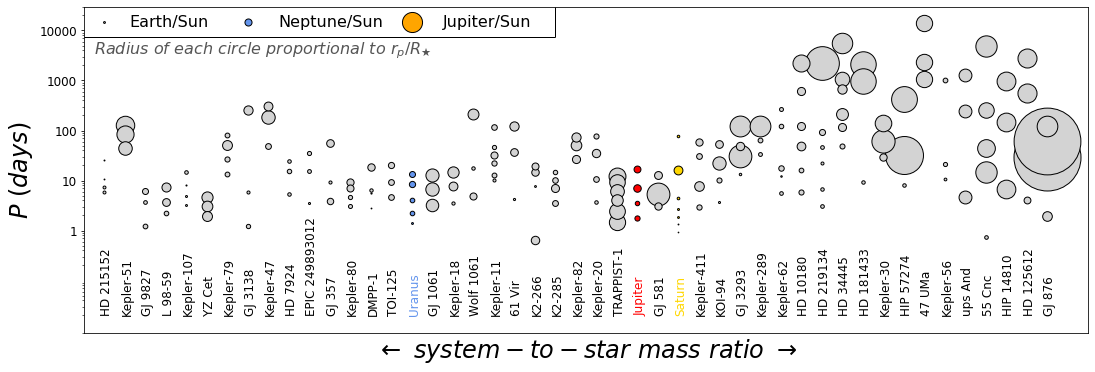

In [12]:
mu_rank = np.array(stats.rankdata(mu_final)-1, dtype = 'int')
mu_pos = mu_rank

plt.figure(figsize = (18, 6))
plt.tight_layout()

for i in range(len(rprs_final)):
    print(str(p_final[i]) + " " + stars_that_matter[i])

for i in range(len(rprs_final)):
    if stars_that_matter[i] == "Jupiter":
        plt.text(mu_pos[i]-0.2, 0.02, stars_that_matter[i], rotation = 90, va = 'bottom', fontsize = 12, color = 'red')
    elif stars_that_matter[i] == "Saturn":
        plt.text(mu_pos[i]-0.2, 0.02, stars_that_matter[i], rotation = 90, va = 'bottom', fontsize = 12, color = 'gold')
    elif stars_that_matter[i] == "Uranus":
        plt.text(mu_pos[i]-0.2, 0.02, stars_that_matter[i], rotation = 90, va = 'bottom', \
                 fontsize = 12, color = 'cornflowerblue')
    else:
        plt.text(mu_pos[i]-0.2, 0.02, stars_that_matter[i], rotation = 90, va = 'bottom', fontsize = 12)
    for j in range(len(rprs_final[i])):
        if stars_that_matter[i] == "Jupiter":
            plt.plot(mu_pos[i], p_final[i][j], 'o', markersize = 200*rprs_final[i][j], mec = 'k', mew = 1, \
                 zorder = -200*rprs_final[i][j], color = 'red')
        elif stars_that_matter[i] == "Saturn":
            plt.plot(mu_pos[i], p_final[i][j], 'o', markersize = 200*rprs_final[i][j], mec = 'k', mew = 1, \
                 zorder = -200*rprs_final[i][j], color = 'gold')
        elif stars_that_matter[i] == "Uranus":
            plt.plot(mu_pos[i], p_final[i][j], 'o', markersize = 200*rprs_final[i][j], mec = 'k', mew = 1, \
                 zorder = -200*rprs_final[i][j], color = 'cornflowerblue')
        else:
            plt.plot(mu_pos[i], p_final[i][j], 'o', markersize = 200*rprs_final[i][j], mec = 'k', mew = 1, \
                 zorder = -200*rprs_final[i][j], color = 'lightgrey')
        


plt.xticks([])
plt.xlabel(r'$\leftarrow\ system-to-star\ mass\ ratio\ \rightarrow$', fontsize=24)

plt.ylabel(r'$P\ (days)$', fontsize=24)

plt.xlim(-1, max(mu_pos)+2)

plt.yscale('log')
plt.yticks([1, 10, 100, 1000, 10000], [1, 10, 100, 1000, 10000], fontsize = 12)

plt.ylim(0.009, 30000)



plt.hlines(7500, -1, 22, lw = 1)
plt.vlines(22, 7500, 30000, lw = 1)
plt.plot(0, 15000, 'o', markersize=200/(RSUN/REARTH), color='lightgrey', mec='k', mew=1)
plt.text(1.2, 15000, 'Earth/Sun', va='center', fontsize=16)
plt.plot(7, 15000, 'o', markersize=200/(RSUN/RNEPTUNE), color='cornflowerblue', mec='k', mew=1)
plt.text(8.5, 15000, 'Neptune/Sun', va='center', fontsize=16)
plt.plot(15, 15000, 'o', markersize=200/(RSUN/RJUPITER), color='orange', mec='k', mew=1)
plt.text(16.5, 15000, 'Jupiter/Sun', va='center', fontsize=16)





'''
The large planet on the right, Gilese 876b, is about 0.5% the mass of its star, so the radius here is going to be greater
than 1.  Also, I assume Gilese 876c is the planet that appears to be just behind Gilese 876b.
'''


plt.text(-0.5,6500, r'$Radius\ of\ each\ circle\ proportional\ to\ r_p/R_{\bigstar}$', \
         fontsize=16, color='#555555', va='top')
 
plt.show()